In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

## <b><u>Stat Sig Tests In Summary</b></u>
### <b><u>Prioritize Performance Metrics:</b></u> Focus on overall model performance to evaluate how well your model predicts outcomes.
### <b><u>Use Significance Tests as One Tool:</b></u> They can help identify which predictors might be important, 
### but they are not the only measure of a model’s effectiveness.
### <b><u>Consider Context and Practical Implications:</b></u> Think about whether a predictor is meaningful in the context of your specific problem, regardless of its statistical significance.

## Data descriptions:
doi: 10.24432/C5002N
<br><br>AP (Ambient Pressure) Feature,	Continuous, (range 992.89-1033.30 milibar)	units:milibar
<br>RH	(Residual Humidity) Feature,	Continuous, (range 25.56% to 100.16%)	units:%
<br>AT	(Ambient Temperature) Feature,	Continuous,	(range 1.81°C and 37.11°C)	units: C
<br>V (Exhaust Vacuum)	Feature	Continuous (range 25.36-81.56 cm Hg)        	units: cm Hg
<br><br>PE	(Net hourly electrical output of the plant) Target,	Continuous,	(range 420.26-495.76 MW)	units:MW
 
<b><u>combined cycle power plant:</b></u>
<br>-electricity of the plant is generated by steam,gas turbines, and returned heat
<br>-the vacuum is colected from and has effect on the steam turbine
<br>-ambient variables affect gas turbine performance


## Project goal:
use environment features to predict net hourly electrical energy output of the plant (EP)

In [2]:
df = pd.read_csv('CombinedCyclePowerPlant.csv', sep=',')
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,9568.0,19.651231,7.452473,1.81,13.5100,20.345,25.72,37.11
V,9568.0,54.305804,12.707893,25.36,41.7400,52.080,66.54,81.56
AP,9568.0,1013.259078,5.938784,992.89,1009.1000,1012.940,1017.26,1033.30
RH,9568.0,73.308978,14.600269,25.56,63.3275,74.975,84.83,100.16
PE,9568.0,454.365009,17.066995,420.26,439.7500,451.550,468.43,495.76


Text(0.5, 1.0, 'PE (target) hist')

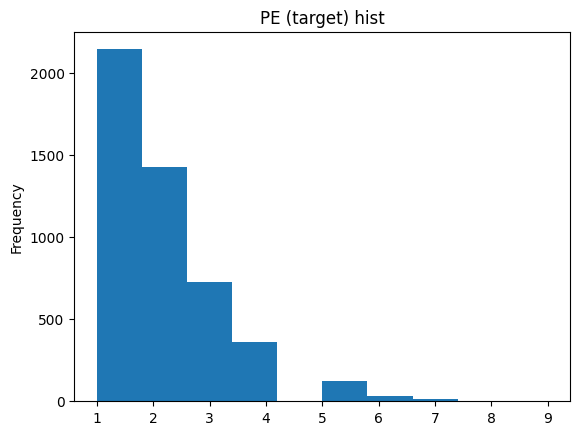

In [4]:
df['PE'].value_counts().plot(kind='hist')
plt.title('PE (target) hist')

Text(0.5, 1.0, 'AP hist')

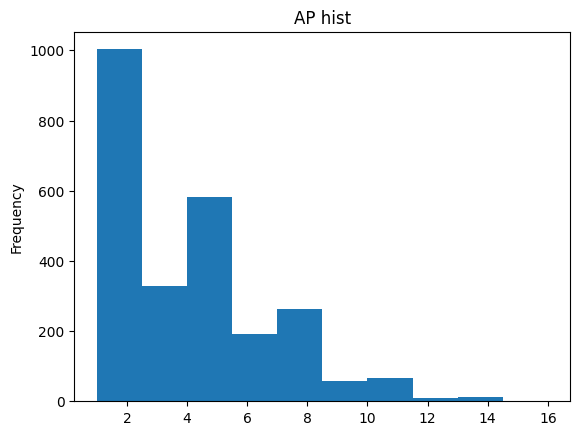

In [5]:
df['AP'].value_counts().plot(kind='hist')
plt.title('AP hist')

Text(0.5, 1.0, 'RH hist')

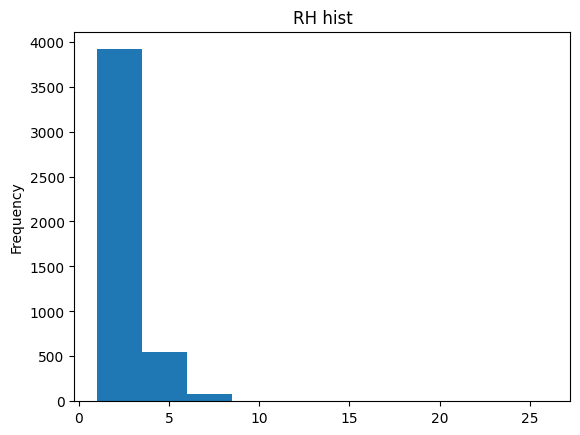

In [6]:
df['RH'].value_counts().plot(kind='hist')
plt.title('RH hist')

Text(0.5, 1.0, 'AT hist')

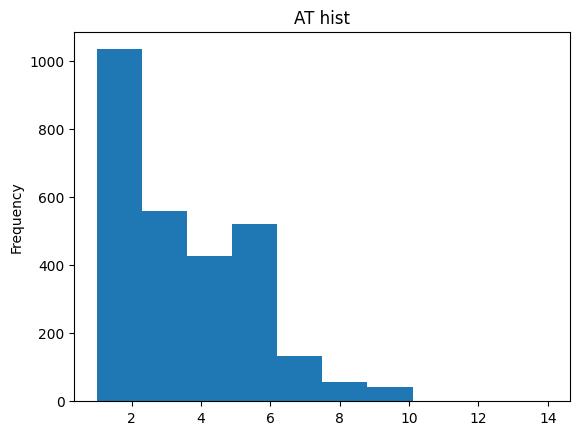

In [7]:
df['AT'].value_counts().plot(kind='hist')
plt.title('AT hist')

Text(0.5, 1.0, 'V hist')

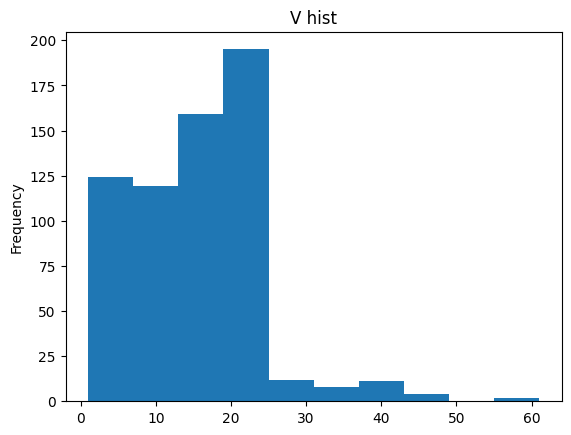

In [8]:
df['V'].value_counts().plot(kind='hist')
plt.title('V hist')

Text(0.5, 1.0, 'RH hist')

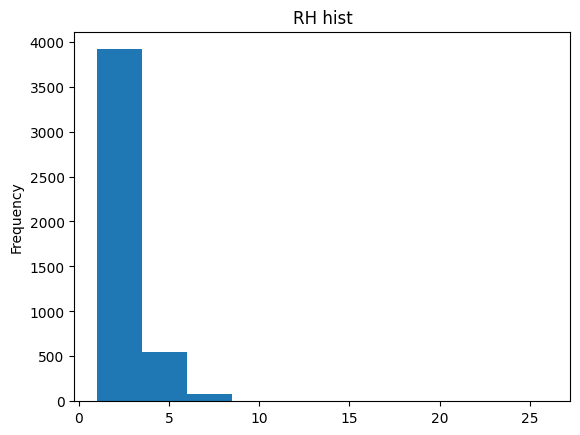

In [9]:
df['RH'].value_counts().plot(kind='hist')
plt.title('RH hist')

In [10]:
df.isnull().describe()

,AT,V,AP,RH,PE
count,9568,9568,9568,9568,9568
unique,1,1,1,1,1
top,False,False,False,False,False
freq,9568,9568,9568,9568,9568


In [11]:
import wolta
wolta.data_tools.col_types(df)

['float64', 'float64', 'float64', 'float64', 'float64']

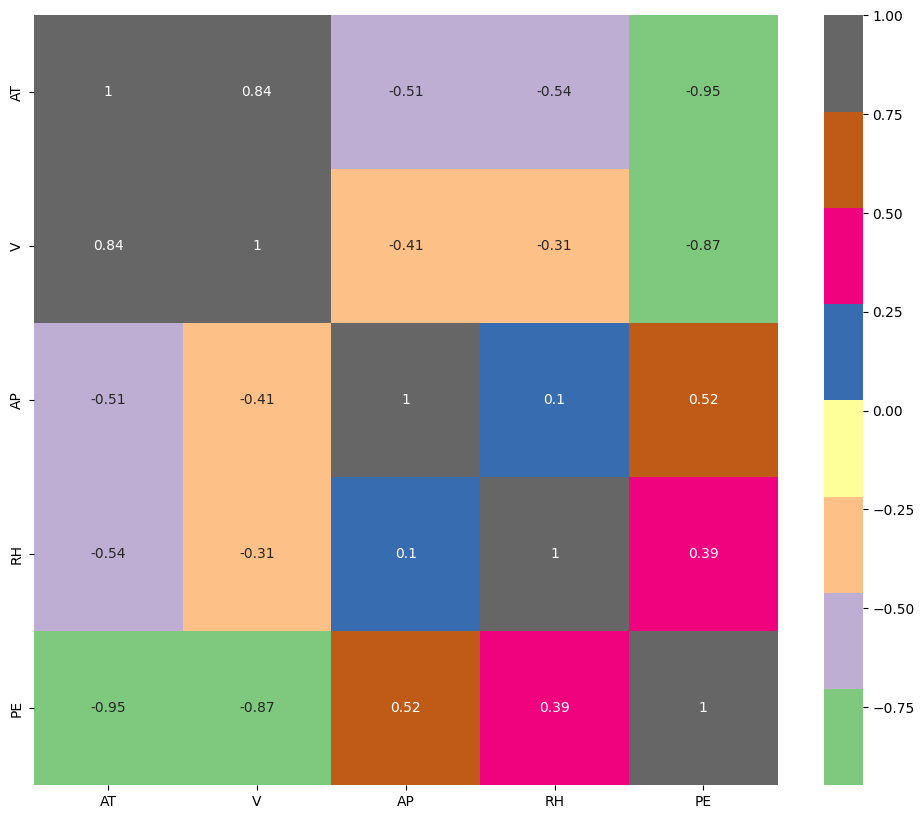

In [12]:
# pearson correlation
df.corr(method='pearson')
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Accent)
plt.show()

AP and PE: 0.52 (moderate corr)
<br>RH and PE: 0.39 (weark/moderate corr)
<br> V and PE: -0.87  (strong negative association to PE)
<br>AT and PE: -0.95 (strong negative association to PE)

#### Check normality via Shapiro-Wilk test

In [13]:
from scipy.stats import shapiro

# Assuming 'data' is your dataset
stat, p = shapiro(df)
print(f'Statistics={stat}, p={p}')
if p > 0.05:
    print('Data looks normal (fail to reject H0)')
else:
    print('Data does not look normal (reject H0)')

Statistics=0.7258657990679025, p=6.61010765439089e-123
Data does not look normal (reject H0)


## AP vs PE (corr = 0.52)

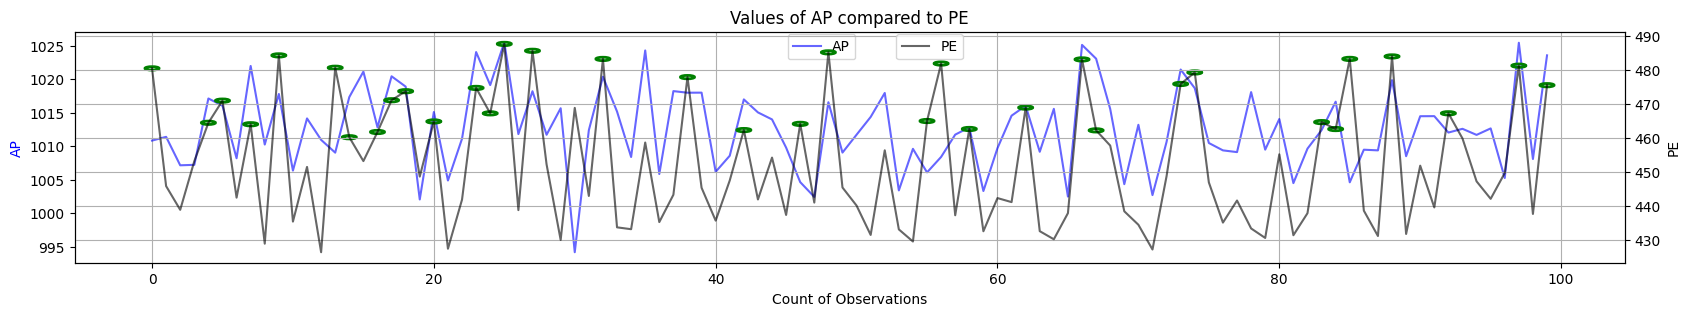

In [14]:
# Names
indep_name = 'AP'
dep_name = 'PE'

# Values [start:stop:step size]
indep = df[indep_name].values[:100:1]
dep = df[dep_name].values[:100:1]

# Plot axis
fig, ax1 = plt.subplots(figsize=(20, 3))
plt.title(f'Values of {indep_name.upper()} compared to {dep_name.upper()}')

# Plot Independent variable
plt.plot(indep, color='b', alpha=0.6)
ax1.set_ylabel(indep_name.upper(), color='b')
ax1.set_xlabel('Count of Observations')
plt.legend([indep_name], loc=(0.46,0.88))

# Overlay each on same axis
ax2 = ax1.twinx()

# Plot Dependent variable
plt.plot(dep, color='black', alpha=0.6)
ax2.set_ylabel(dep_name.upper(), color='black')
plt.legend([dep_name], loc=(0.53, 0.88))

# Circle specified correlation areas
for i in range(len(indep)):
    if indep[i] > 1000 and dep[i] > 460:  # Modify conditions as needed
        circle = plt.Circle(
            (i, dep[i]),
            0.5,
            color='green',
            fill=False,
            linewidth=2
)  
        ax2.add_patch(circle)

plt.grid(True) #hor grid
ax1.xaxis.grid(True) #vert grid
plt.show()

# Clear variable memory to free storage
# for large datasets
del dep
del indep

## RH vs PE (corr = 0.39)

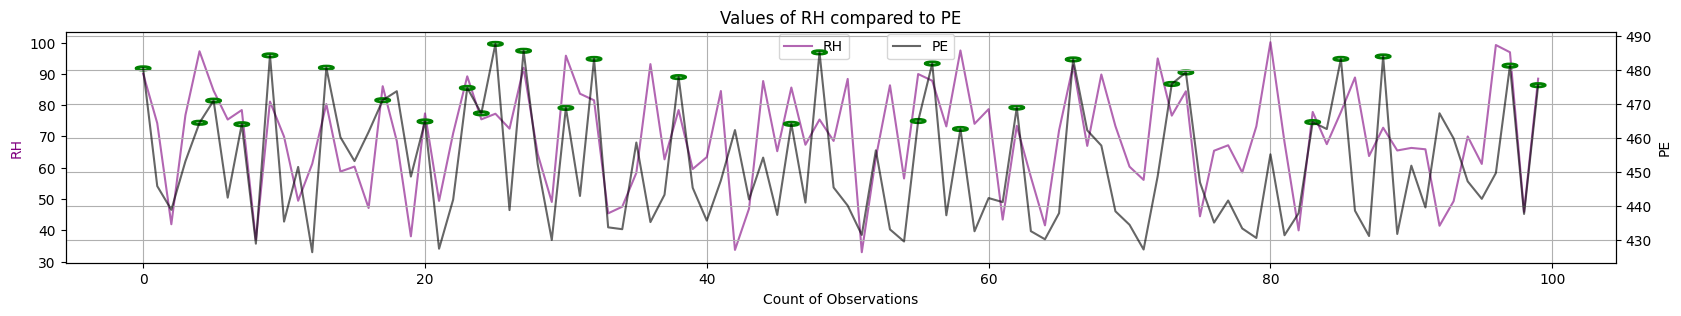

In [15]:
# Names
indep_name = 'RH'
dep_name = 'PE'

# Values [start:stop:step size]
indep = df[indep_name].values[:100:1]
dep = df[dep_name].values[:100:1]

# Plot axis
fig, ax1 = plt.subplots(figsize=(20, 3))
plt.title(f'Values of {indep_name.upper()} compared to {dep_name.upper()}')

# Plot Independent variable
plt.plot(indep, color='purple', alpha=0.6)
ax1.set_ylabel(indep_name.upper(), color='purple')
ax1.set_xlabel('Count of Observations')
plt.legend([indep_name], loc=(0.46,0.88))

# Overlay each on same axis
ax2 = ax1.twinx()

# Plot Dependent variable
plt.plot(dep, color='black', alpha=0.6)
ax2.set_ylabel(dep_name.upper(), color='black')
plt.legend([dep_name], loc=(0.53, 0.88))

# Circle specified correlation areas
for i in range(len(indep)):
    if indep[i] > 70 and dep[i] > 460:  # Modify conditions as needed
        circle = plt.Circle(
            (i, dep[i]),
            0.5,
            color='green',
            fill=False,
            linewidth=2
)  
        ax2.add_patch(circle)

plt.grid(True) #hor grid
ax1.xaxis.grid(True) #vert grid
plt.show()

# Clear variable memory to free storage
# for large datasets
del dep
del indep

### AT vs PE (corr: -0.95, weak negative to no correlation )

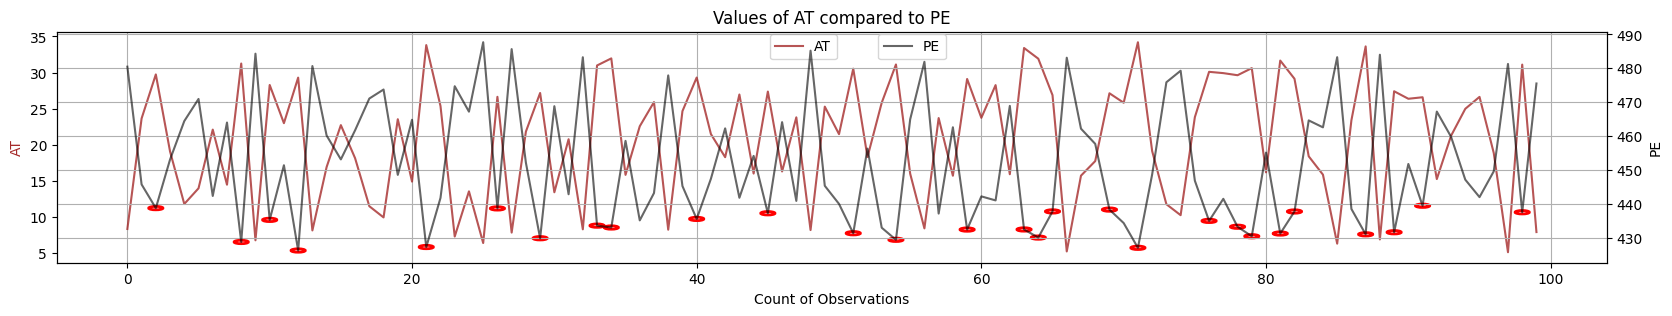

In [16]:
# Names
indep_name = 'AT'
dep_name = 'PE'

# Values [start:stop:step size]
indep = df[indep_name].values[:100:1]
dep = df[dep_name].values[:100:1]

# Plot axis
fig, ax1 = plt.subplots(figsize=(20, 3))
plt.title(f'Values of {indep_name.upper()} compared to {dep_name.upper()}')

# Plot Independent variable
plt.plot(indep, color='brown', alpha=0.8)
ax1.set_ylabel(indep_name.upper(), color='brown')
ax1.set_xlabel('Count of Observations')
plt.legend([indep_name], loc=(0.46,0.88))


# Overlay each on same axis
ax2 = ax1.twinx()

# Plot Dependent variable
plt.plot(dep, color='black', alpha=0.6)
ax2.set_ylabel(dep_name.upper(), color='black')
plt.legend([dep_name], loc=(0.53, 0.88))

# Circle specified correlation areas
for i in range(len(indep)):
    if indep[i] > 26 and dep[i] < 440:  # Modify conditions as needed
        circle = plt.Circle(
            (i, dep[i]),
            0.5,
            color='red',
            fill=False,
            linewidth=2
)  
        ax2.add_patch(circle)

plt.grid(True) #hor grid
ax1.xaxis.grid(True) #vert grid
plt.show()

# Clear variable memory to free storage
# for large datasets
del dep
del indep

### V vs PE (corr -0.87, weak negative to no correlation )

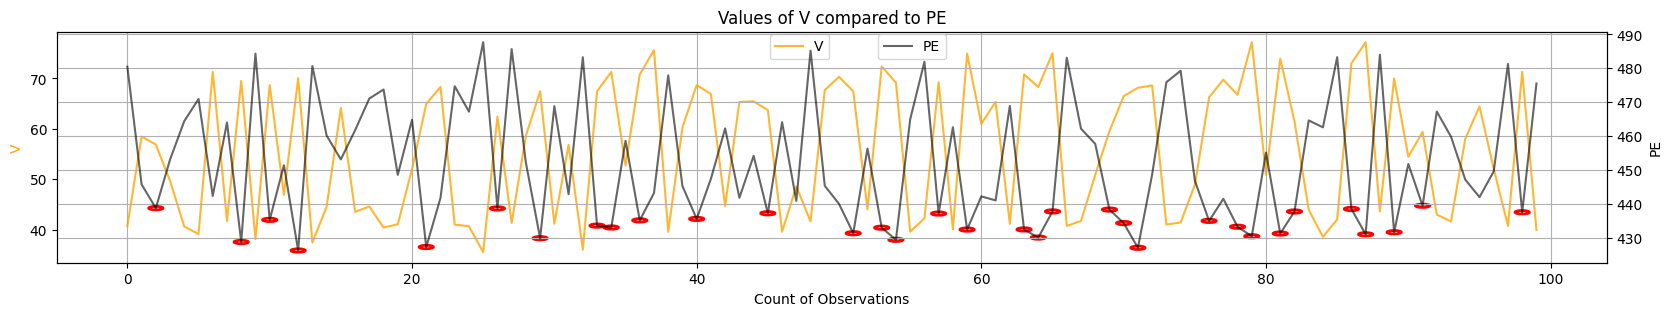

In [17]:
# Names
indep_name = 'V'
dep_name = 'PE'

# Values [start:stop:step size]
indep = df[indep_name].values[:100:1]
dep = df[dep_name].values[:100:1]

# Plot axis
fig, ax1 = plt.subplots(figsize=(20, 3))
plt.title(f'Values of {indep_name.upper()} compared to {dep_name.upper()}')

# Plot Independent variable
plt.plot(indep, color='orange', alpha=0.8)
ax1.set_ylabel(indep_name.upper(), color='orange')
ax1.set_xlabel('Count of Observations')
plt.legend([indep_name], loc=(0.46,0.88))

# Overlay each on same axis
ax2 = ax1.twinx()

# Plot Dependent variable
plt.plot(dep, color='black', alpha=0.6)
ax2.set_ylabel(dep_name.upper(), color='black')
plt.legend([dep_name], loc=(0.53, 0.88)) #hor, vert

# Circle specified correlation areas
for i in range(len(indep)):
    if indep[i] > 40 and dep[i] < 440:  # Modify conditions as needed
        circle = plt.Circle(
            (i, dep[i]),
            0.5,
            color='red',
            fill=False,
            linewidth=2
)  
        ax2.add_patch(circle)

plt.grid(True) #hor grid
ax1.xaxis.grid(True) #vert grid
plt.show()

# Clear variable memory to free storage
# for large datasets
del dep
del indep

# Regression plot

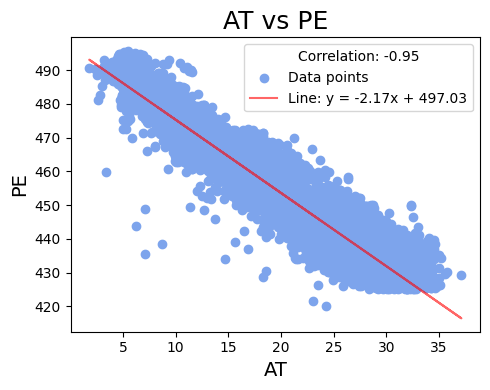

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Set the feature and target variable names
x_name = 'AT'
y_name = 'PE'

# Extract the variables
x = df[x_name]
y = df[y_name]

# Create the figure with specified size
plt.figure(figsize=(5, 4))  # (height, width)

# Scatter plot
plt.scatter(x, y, color='#7da4ec', label='Data points')

# Fit a linear regression line (y = mx + b)
m, b = np.polyfit(x, y, 1)

# Plot the regression line
plt.plot(x, m*x + b, color='red', alpha=0.6, label=f'Line: y = {m:.2f}x + {b:.2f}')

# Calculate correlation
correlation = np.corrcoef(x, y)[0, 1]

# Add the correlation value to the legend
plt.legend(title=f'Correlation: {correlation:.2f}')

# Add labels and title
plt.xlabel(x_name, size=14)
plt.ylabel(y_name, size=14)
plt.title(f'{x_name} vs {y_name}', size=18)

# Show the plot with tight layout
plt.tight_layout()
plt.show()

### Multiple regression plots

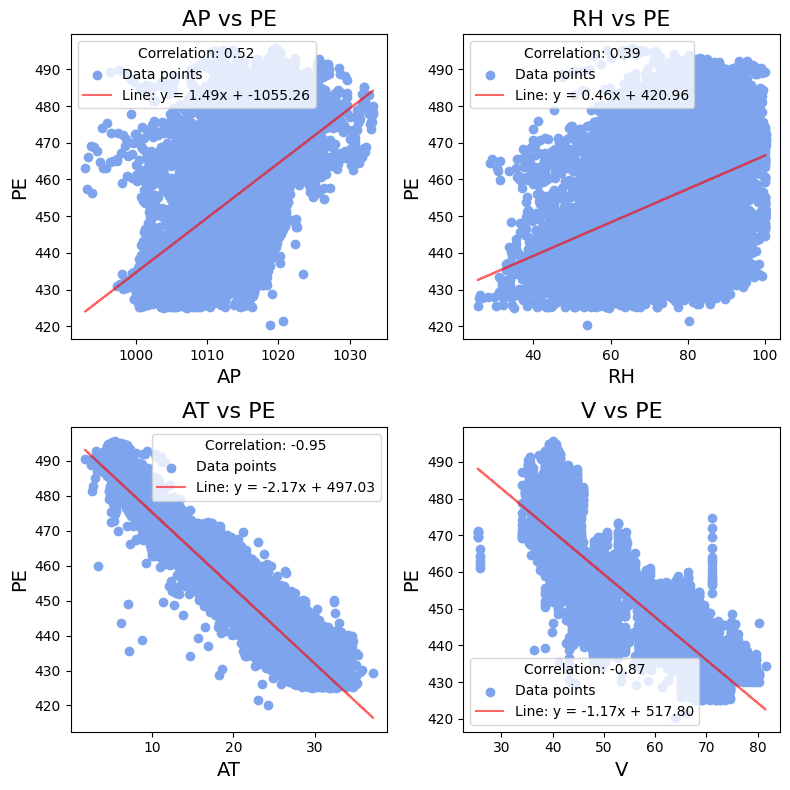

In [19]:
# Define the independent variables
independent_vars = ['AP', 'RH', 'AT', 'V']
y_name = 'PE'

# Create a figure for all plots
plt.figure(figsize=(8, 8)) # (height, width)

# Loop through independent variables and create plots
for i, x_name in enumerate(independent_vars):
    plt.subplot(2, 2, i + 1)  # 2x2 grid of plots
    x = df[x_name]
    y = df[y_name]
    
    plt.scatter(x, y, color='#7da4ec', label='Data points')
    
    # Fit a linear regression line (y = mx + b)
    m, b = np.polyfit(x, y, 1)
    
    # Plot the regression line
    plt.plot(x, m*x + b, color='red', alpha=0.6, label=f'Line: y = {m:.2f}x + {b:.2f}')
    
    # Calculate correlation
    correlation = np.corrcoef(x, y)[0, 1]
    
    # Add the correlation value to the legend
    plt.legend(title=f'Correlation: {correlation:.2f}')
    
    # Add labels and title
    plt.xlabel(x_name, size=14)
    plt.ylabel(y_name, size=14)
    plt.title(f'{x_name} vs {y_name}', size=16)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

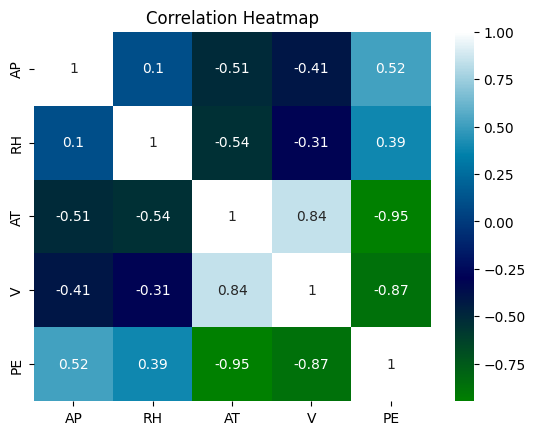

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[['AP', 'RH', 'AT', 'V', 'PE']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='ocean')
plt.title('Correlation Heatmap')
plt.show()

In [21]:
# Correlation of AT with other variables
corr_at = correlation_matrix['AT']

# Display correlations
print("Correlation of AT with other variables:")
print(corr_at)

Correlation of AT with other variables:
AP   -0.507549
RH   -0.542535
AT    1.000000
V     0.844107
PE   -0.948128
Name: AT, dtype: float64


# Boxplots

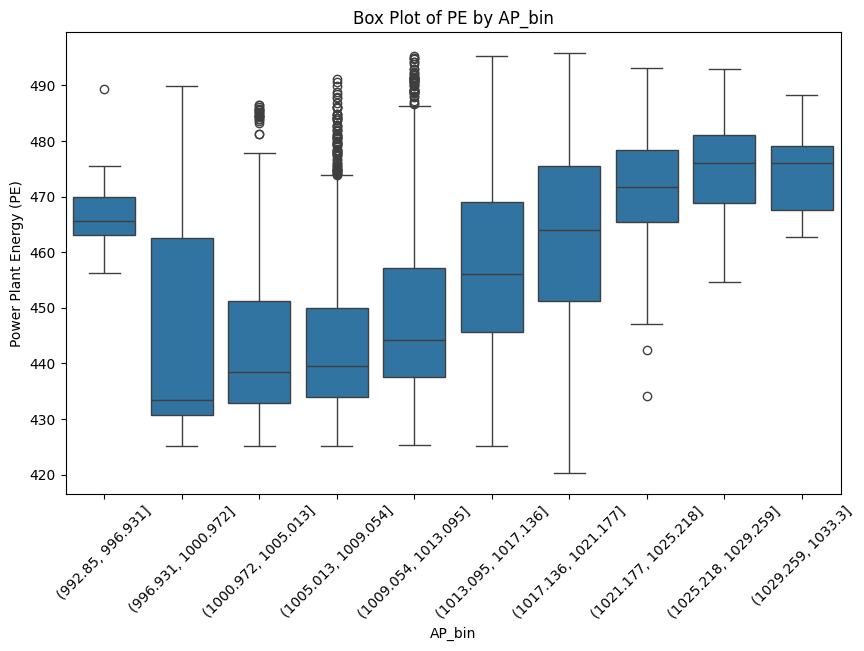

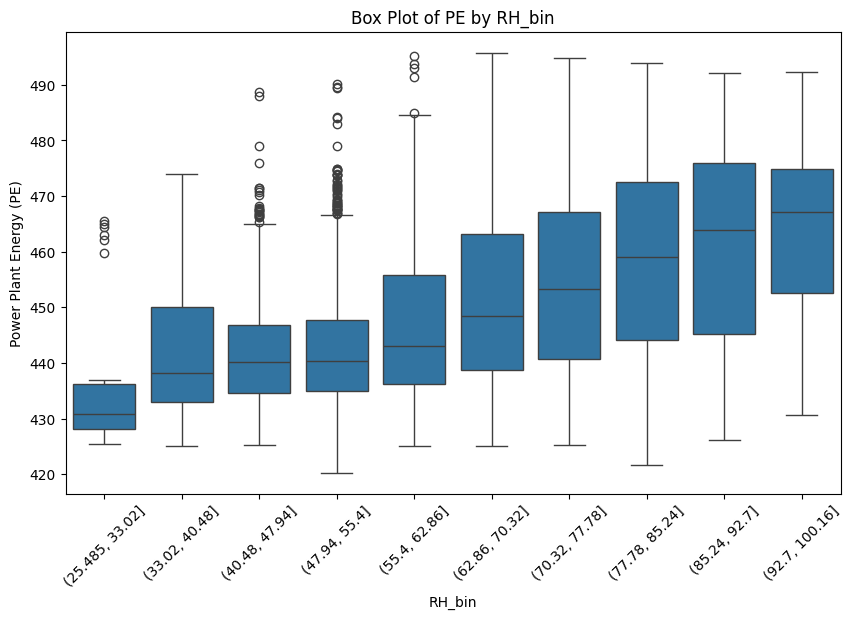

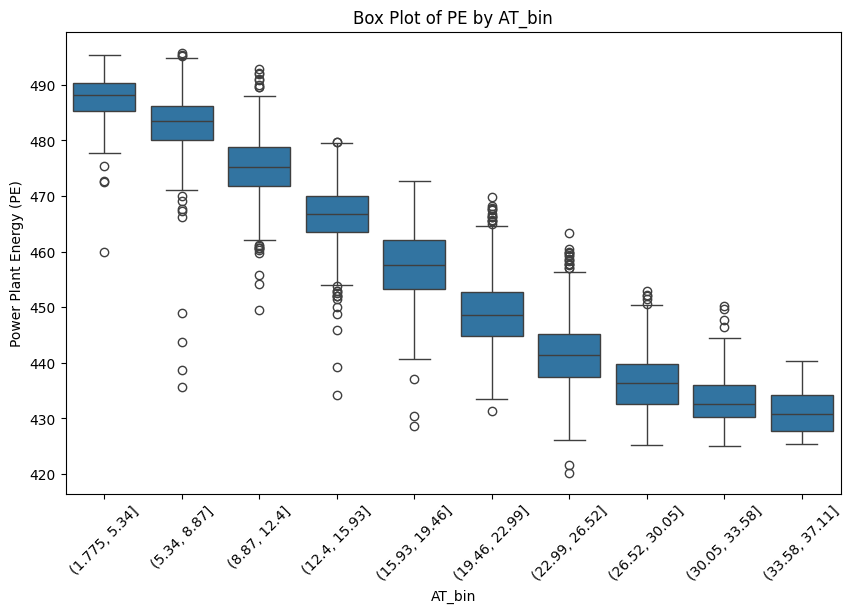

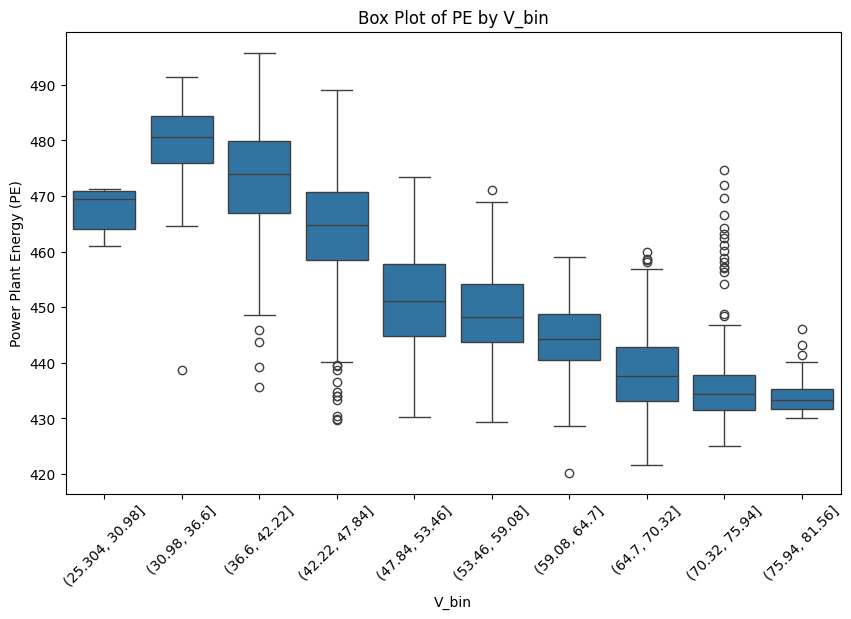

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new DataFrame with categorical bins for each feature
# This example will categorize continuous features into bins.
df['AP_bin'] = pd.cut(df['AP'], bins=10)
df['RH_bin'] = pd.cut(df['RH'], bins=10)
df['AT_bin'] = pd.cut(df['AT'], bins=10)
df['V_bin'] = pd.cut(df['V'], bins=10)

# List of binned features
binned_features = ['AP_bin', 'RH_bin', 'AT_bin', 'V_bin']

# Create box plots for each binned feature against PE
for feature in binned_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='PE', data=df)
    plt.title(f'Box Plot of PE by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Power Plant Energy (PE)')
    plt.xticks(rotation=45)
    plt.show()

 Ideally, you want to see less spread (i.e., smaller interquartile ranges and less variability) within each bin. This indicates that for a specific range of the feature, the target variable (PE) tends to have consistent values. Consistency can improve the reliability of your regression predictions.

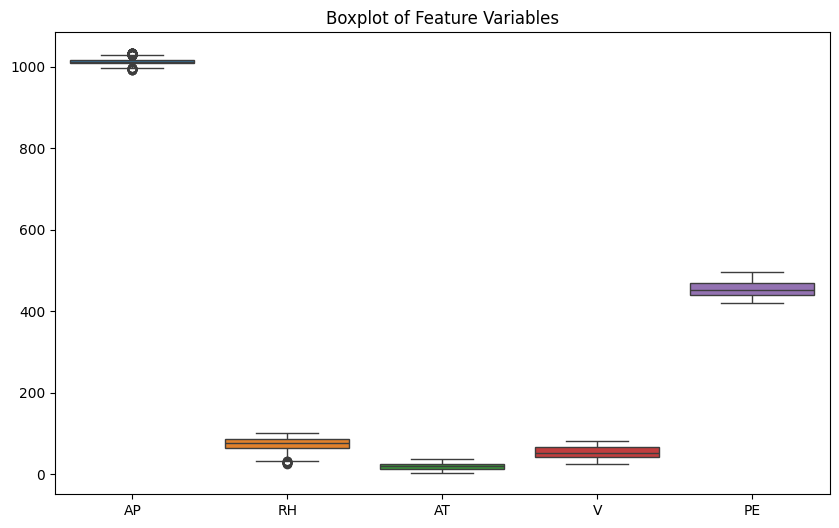

In [67]:
plt.figure(figsize=(10, 6))
# Boxplot to visualize outliers
sns.boxplot(data=df[['AP', 'RH', 'AT', 'V', 'PE']])
plt.title('Boxplot of Feature Variables')
plt.show()

(a) Boxplots for visualizing outliers:

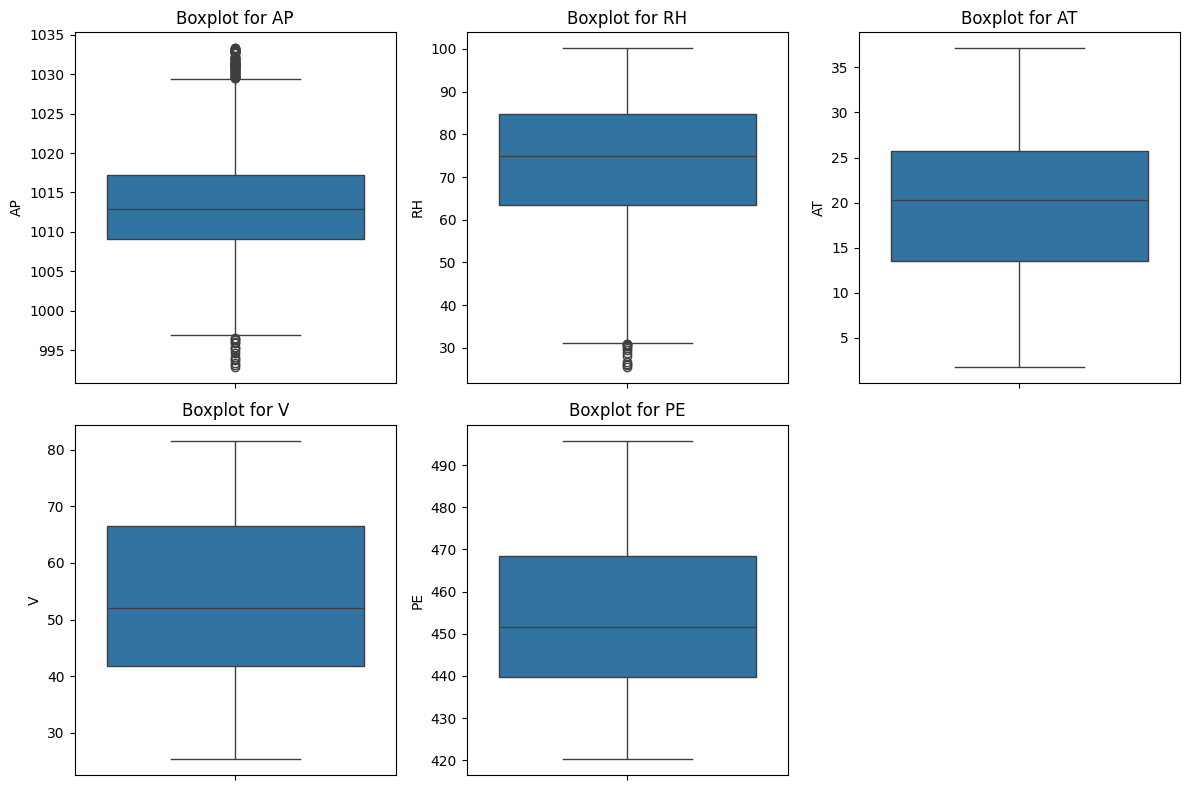

In [39]:
# Create boxplots for each feature variable
features = ['AP', 'RH', 'AT', 'V', 'PE']
plt.figure(figsize=(12, 8))

for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

# OLS Regression Tests - Full Variables vs Reduced

In [23]:
import statsmodels.api as sm

# Define the features and target variable
X = df[['AP', 'RH', 'AT', 'V']]
y = df['PE']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:31:40   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

## The null hypothesis of F-test states that 
## the reduced model fits the data as well as the full model.
## Instead of just looking at individual significance, consider overall model performance metrics (like R-squared, RMSE, or MAE).
## These give a better picture of how well the model predicts the target variable.

In [24]:
# Fit a reduced model (e.g., excluding one or more predictors)
X_reduced = df[['AP', 'AT']]  # Example of a reduced model
X_reduced = sm.add_constant(X_reduced)
reduced_model = sm.OLS(y, X_reduced).fit()

# Perform an F-test
f_test = model.compare_f_test(reduced_model)
print("F-test statistic:", f_test[0])
print("p-value:", f_test[1])

F-test statistic: 1869.830274207753
p-value: 0.0


 p-value near zero =  the reduced model does not adequately capture the variance in the target variable (PE) compared to the full model.

In [25]:
#test all reduced models
import pandas as pd
import statsmodels.api as sm
import itertools

# Define the features and target variable
X = df[['AP', 'RH', 'AT', 'V']]
y = df['PE']

# Add a constant to the full model
X_full = sm.add_constant(X)
full_model = sm.OLS(y, X_full).fit()

# Print the summary of the full model
print("Full Model Summary:")
print(full_model.summary())
print("\n")

# Generate all combinations of feature variables
features = X.columns
results = []

for i in range(1, len(features) + 1):
    for combo in itertools.combinations(features, i):
        # Define the reduced model using the combination of features
        X_reduced = X[list(combo)]
        X_reduced = sm.add_constant(X_reduced)
        reduced_model = sm.OLS(y, X_reduced).fit()
        
        # Perform the F-test
        f_test_result = full_model.compare_f_test(reduced_model)
        
        # Store the results
        results.append({
            'Features': combo,
            'F-statistic': f_test_result[0],
            'p-value': f_test_result[1],
            'Reduced Model Summary': reduced_model.summary()
        })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df[['Features', 'F-statistic', 'p-value']])

Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:31:40   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749

Threshold: A condition number above 30 often suggests potential multicollinearity issues, and values greater than 100 or 1000 indicate serious problems.

# Our condition number is: 213,000

# VIF

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  Feature        VIF
0      AP  66.618618
1      RH  40.704756
2      AT  39.157705
3       V  74.969127


## If VIF values are high (typically above 10), it indicates multicollinearity. 
## Consider removing or combining features that are highly correlated with each other.

Feature Transformation:

Sometimes, transforming features (e.g., taking the logarithm or scaling) can help alleviate multicollinearity issues.
Principal Component Analysis (PCA):

PCA can be used to reduce dimensionality and create uncorrelated features from your correlated predictors. This can help mitigate multicollinearity while retaining the variance of the data.
Regularization Techniques:

Consider using regularized regression techniques like Lasso or Ridge regression, which can handle multicollinearity more effectively by adding a penalty term to the loss function.

In cases of high collinearity, models using techniques like Lasso or Ridge regression can improve interpretability and performance by focusing on the most important features, even if some individual features are not statistically significant.

## Variable removal with VIF check

In [27]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define a function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Define the features and target variable
X = df[['AP', 'RH', 'AT', 'V']]
y = df['PE']

# Iteratively remove features with high VIF
while True:
    vif_data = calculate_vif(X)
    max_vif = vif_data['VIF'].max()
    
    # Check if max VIF is above the threshold (10)
    if max_vif > 10:
        # Get the feature with the highest VIF
        feature_to_remove = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
        print(f"Removing feature: {feature_to_remove} with VIF: {max_vif}")
        X = X.drop(columns=[feature_to_remove])
    else:
        break

# Final VIF after removals
final_vif_data = calculate_vif(X)
print("\nFinal VIF values after removals:")
print(final_vif_data)

Removing feature: V with VIF: 74.96912742501162
Removing feature: AP with VIF: 64.59515215774752

Final VIF values after removals:
  Feature       VIF
0      RH  4.413538
1      AT  4.413538


##  If your model has good predictive accuracy (e.g., low RMSE or high $R^2$ in cross-validation),
## it suggests that it captures the relationships effectively, despite multicollinearity.

Residuals vs Fitted , Q-Q plot

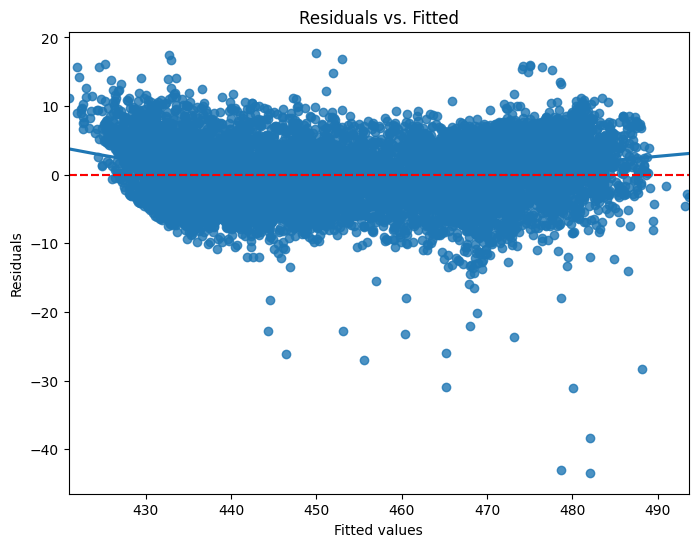

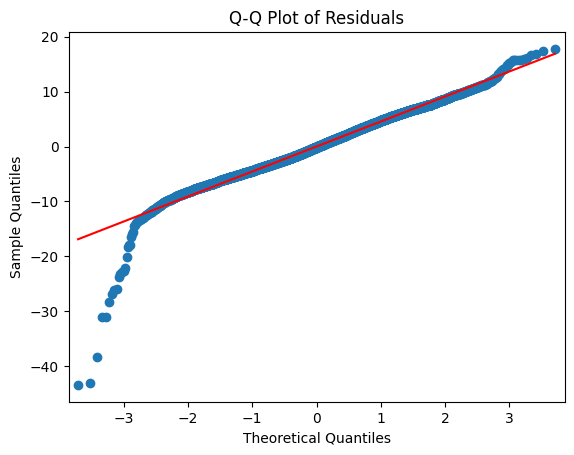

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals vs. Fitted plot
plt.figure(figsize=(8, 6))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Q-Q plot for normality
sm.qqplot(model.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

## 95% Confidence interval for population mean:

In [29]:
import numpy as np
from scipy import stats

# Step 1: Extract the 'PE' column
values = df['PE']

# Step 2: Calculate the sample mean and sample standard deviation
sample_mean = np.mean(values)
sample_std = np.std(values, ddof=1)  # Sample standard deviation
n = len(values)  # Sample size

# Step 3: Set confidence level and corresponding z-value
confidence_level = 0.95
z_value = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # For 95% CI

# Step 4: Calculate margin of error
margin_of_error = z_value * (sample_std / np.sqrt(n))

# Step 5: Calculate confidence interval
lower_bound = sample_mean - margin_of_error
upper_bound = sample_mean + margin_of_error

# Output the result
print(f"95% Confidence Interval for the mean of PE: ({lower_bound}, {upper_bound})")

95% Confidence Interval for the mean of PE: (454.023034240424, 454.7069845722851)


is this comparable to worldwide statistics?

### 2 sample z-test
compare sample proportions

In [30]:
import numpy as np
from scipy import stats

# Step 1: Define the two independent samples (e.g., for groups based on 'indep' variable)
group1 = df['AP']  # First group 
group2 = df['PE']  # Second group

# Step 2: Calculate sample means, variances, and sizes
mean1 = np.mean(group1)
mean2 = np.mean(group2)
std1 = np.std(group1, ddof=1)  # Sample standard deviation
std2 = np.std(group2, ddof=1)  # Sample standard deviation
n1 = len(group1)
n2 = len(group2)

# Step 3: Calculate the z-score
z_score = (mean1 - mean2) / np.sqrt((std1**2 / n1) + (std2**2 / n2))

# Step 4: Calculate the p-value (for two-tailed test)
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

# Output the results
print(f"Z-Score: {z_score}")
print(f"P-Value: {p_value}")

# Step 5: Conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The means are significantly different.")
else:
    print("Fail to reject the null hypothesis: The means are not significantly different.")

Z-Score: 3025.2708470344933
P-Value: 0.0
Reject the null hypothesis: The means are significantly different.


In [31]:


# Define feature variables (AP, RH, AT, V)
X = df[['AP', 'RH', 'AT', 'V']]

# Add a constant for the intercept in the linear regression
X = sm.add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

  Feature           VIF
0   const  43761.151866
1      AP      1.452639
2      RH      1.705290
3      AT      5.977602
4       V      3.943003


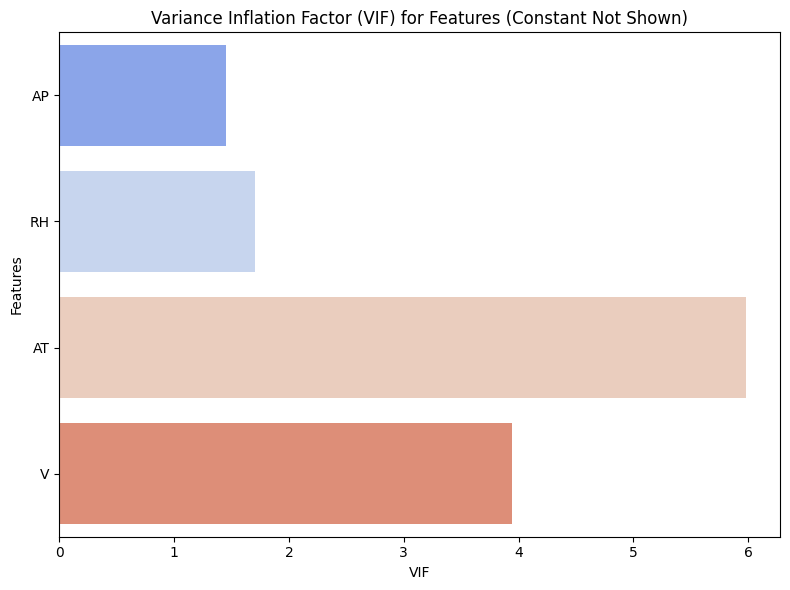

In [32]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature variables (AP, RH, AT, V)
X = df[['AP', 'RH', 'AT', 'V']]

# Add a constant for the intercept in the linear regression
X = sm.add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter out the constant from the DataFrame
vif = vif[vif["Feature"] != "const"]

# Plot VIF values as a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='VIF', y='Feature', data=vif, palette='coolwarm')
plt.title("Variance Inflation Factor (VIF) for Features (Constant Not Shown)")
plt.xlabel("VIF")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## Risk group (AT) VIF between 5 and 10: May indicate moderate multicollinearity. It’s worth checking, but it may not be a major concern unless it’s causing issues with model stability.

VIF$(X_i)$=1 / 1- $R_i^{2}$


Regression Setup: For each independent variable $X_i$, you treat it as the dependent variable and regress it on all other independent variables (excluding $X_i$)



 Fitting the Model: A linear regression is performed, where XiX_iXi is predicted using the other independent variables. The regression equation might look like this:

R^2 is found when fitting a linear regression model

The value of R^2 ranges from 0 to 1, where:
<br>•	R^2 = 1 means perfect prediction (high multicollinearity with other features).
<br>•	R^2 =0 means no relationship between $X_i$ and the other variables.

Calculate R2R^2R2: After fitting the regression, R2R^2R2 is calculated using the formula:
R2=1−SSresSStotR^2 = 1 - \frac{\text{SS}_{\text{res}}}{\text{SS}_{\text{tot}}}R2=1−SStotSSres
•	SSres\text{SS}_{\text{res}}SSres (residual sum of squares): This measures the discrepancy between the actual values of XiX_iXi and the predicted values from the regression model.
•	SStot\text{SS}_{\text{tot}}SStot (total sum of squares): This measures the total variability in XiX_iX


Unstable Coefficients: When features are highly correlated, it becomes difficult to isolate the individual effect of each predictor on the target variable. This leads to unstable and sensitive coefficients that can change drastically with small changes in the data.

Inflated Standard Errors: High collinearity increases the standard errors of the regression coefficients, which makes it harder to determine if predictors are statistically significant. This can lead to false conclusions about which features are important.

Overfitting: Multicollinearity can cause the model to overfit the data, as it may rely heavily on correlated predictors, leading to poor generalization to new, unseen data.

Reduced Interpretability: When predictors are highly correlated, it’s hard to determine which feature is truly driving the prediction. This reduces the interpretability of the model.

If any VIF values are greater than 10, it indicates high multicollinearity.

A value less than 5 suggests that the variable is not strongly correlated with the other predictors, so it's safe to keep in the model.

Between 5 and 10 Indicates moderate multicollinearity. It's not necessarily a problem, but you should carefully check the variables that have VIF in this range to ensure that multicollinearity isn't introducing significant issues into the model.

To check which variables AT (Ambient Temperature) shares collinearity with, you can calculate the correlation matrix and pairwise correlation coefficients between all variables in your dataset. This will show how strongly AT is correlated with other features.

Variance Inflation Factor (VIF): While correlation shows direct pairwise relationships, VIF can indicate collinearity by taking all other variables into account. To see how AT contributes to multicollinearity with others:

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Define the independent variables (features)
X = df[['AP', 'RH', 'AT', 'V']]

# Calculate VIF for each variable - no constant
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

  Variable        VIF
0       AP  66.618618
1       RH  40.704756
2       AT  39.157705
3        V  74.969127


Correlation Matrix: The higher the correlation between AT and another variable (closer to ±1), the more likely they are collinear.

VIF: If you observe high VIF values (above 5 or 10) for variables other than AT, this indicates multicollinearity between those variables and AT.

Remove Highly Correlated Variables:

Identify and remove one or more variables that are highly correlated with others. You can base this decision on the correlation matrix or consider the importance of each variable to your analysis.

## The ANOVA table
### will show the F-statistic and p-values for each main effect and interaction, allowing you to assess the significance of each factor and their combinations in predicting 'PE'.

F-statistic: is calculated by taking the ratio of the variance between the feature variables, to the variance within the groups.

P-value less than 0.05 suggests that there is strong evidence against the null hypothesis, indicating that at least one group mean is significantly different from the others.

(low p and high F = good)

#### The F-statistic in ANOVA tests the null hypothesis that all group means are equal.
#### The F-statistic is a ratio of the variance between group means to the variance within the groups, used to test whether there are significant differences between multiple groups.

posx and posy should be finite values
posx and posy should be finite values


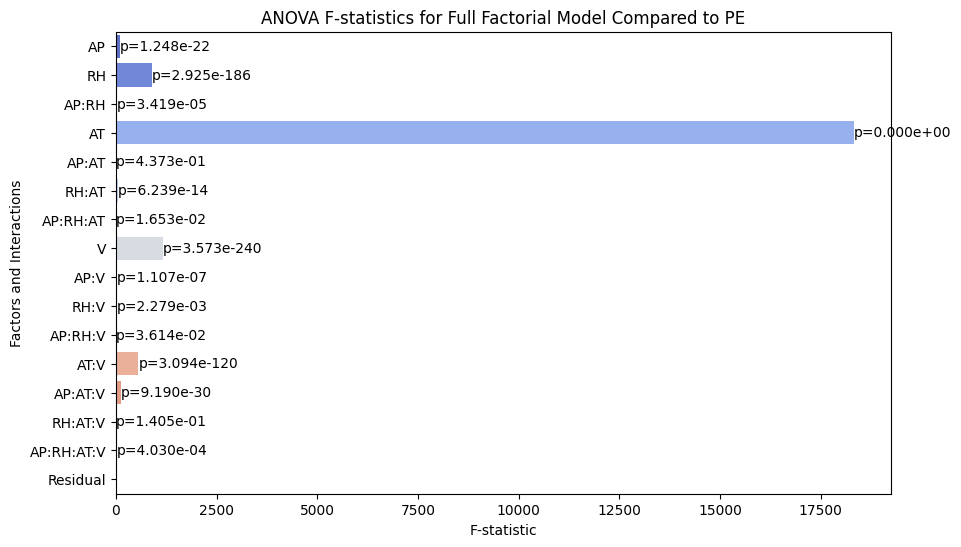

In [34]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains columns AP, RH, AT, V, and PE

# Fit the full factorial model
formula = 'PE ~ AP * RH * AT * V'
model = ols(formula, data=df).fit() #examines how the effect of one variable on PE might depend on the values of the others.

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Extract the F-statistic values and p-values
anova_results = anova_table[['F', 'PR(>F)']].reset_index()
anova_results.columns = ['Factor', 'F_statistic', 'p_value']

# Plot F-statistics with bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='F_statistic', y='Factor', data=anova_results, palette='coolwarm')

# Annotate each bar with its corresponding p-value
for i, row in anova_results.iterrows():
    plt.text(row.F_statistic + 0.1, i, f'p={row.p_value:.3e}', color='black', va='center')

# Add title and labels
plt.title("ANOVA F-statistics for Full Factorial Model Compared to PE")
plt.xlabel("F-statistic")
plt.ylabel("Factors and Interactions")
plt.show()

## The high F-statistic for AT suggests it explains much of the variance in the target variable (PE).
## However, other variables may still offer valuable explanatory power when considered together in the model, even if their individual F-statistics are lower.

F-statistic tells you the ratio of explained to unexplained variance.

Small F (near 1): Little evidence of difference between group means. This might indicate the factor or interaction has little impact on the target variable (in your case, PE).

Moderate F: Some difference between group means, but not extremely strong.

Large F: Strong evidence that group means differ, suggesting the factor/interaction significantly affects the target variable.

p-value shows the statistical significance of that result.

Low p-value (< 0.05): Indicates that the factor or interaction likely has a significant effect on the target variable (PE). You reject the null hypothesis, suggesting that the effect is real.

High p-value (> 0.05): Suggests that the factor or interaction does not have a statistically significant effect, and you fail to reject the null hypothesis.

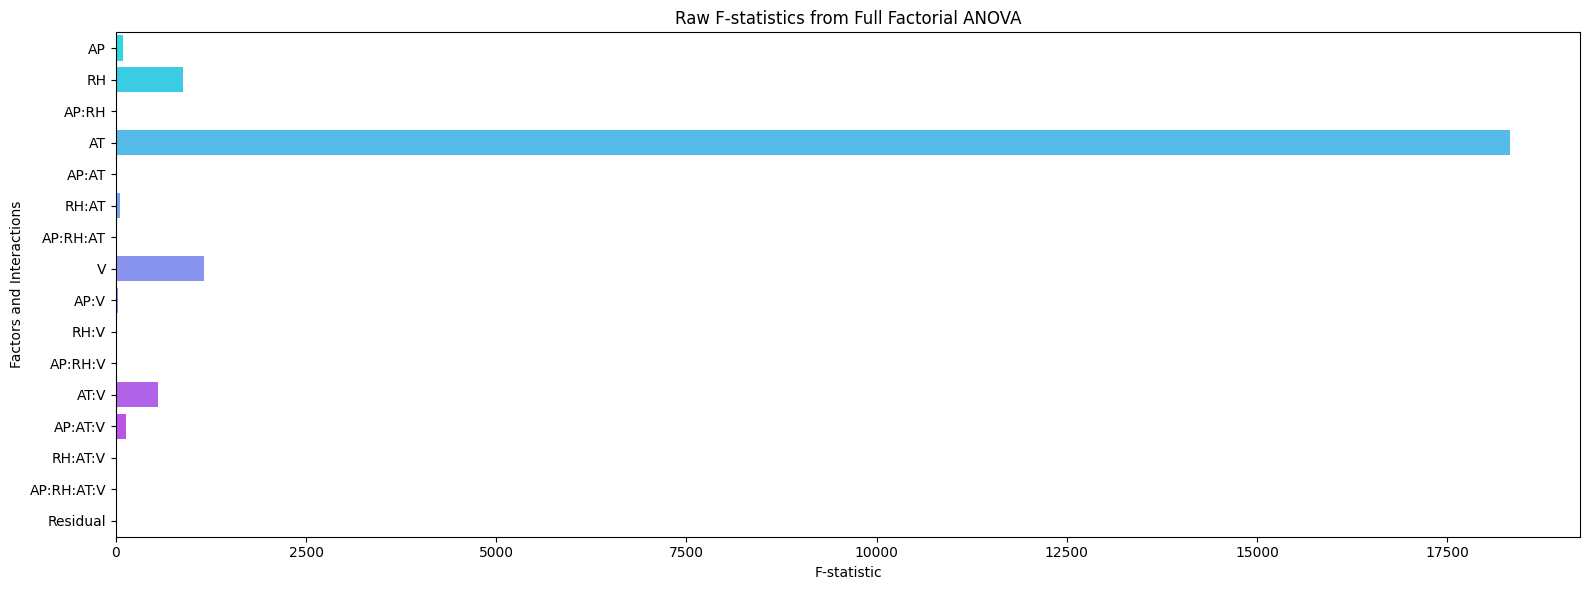

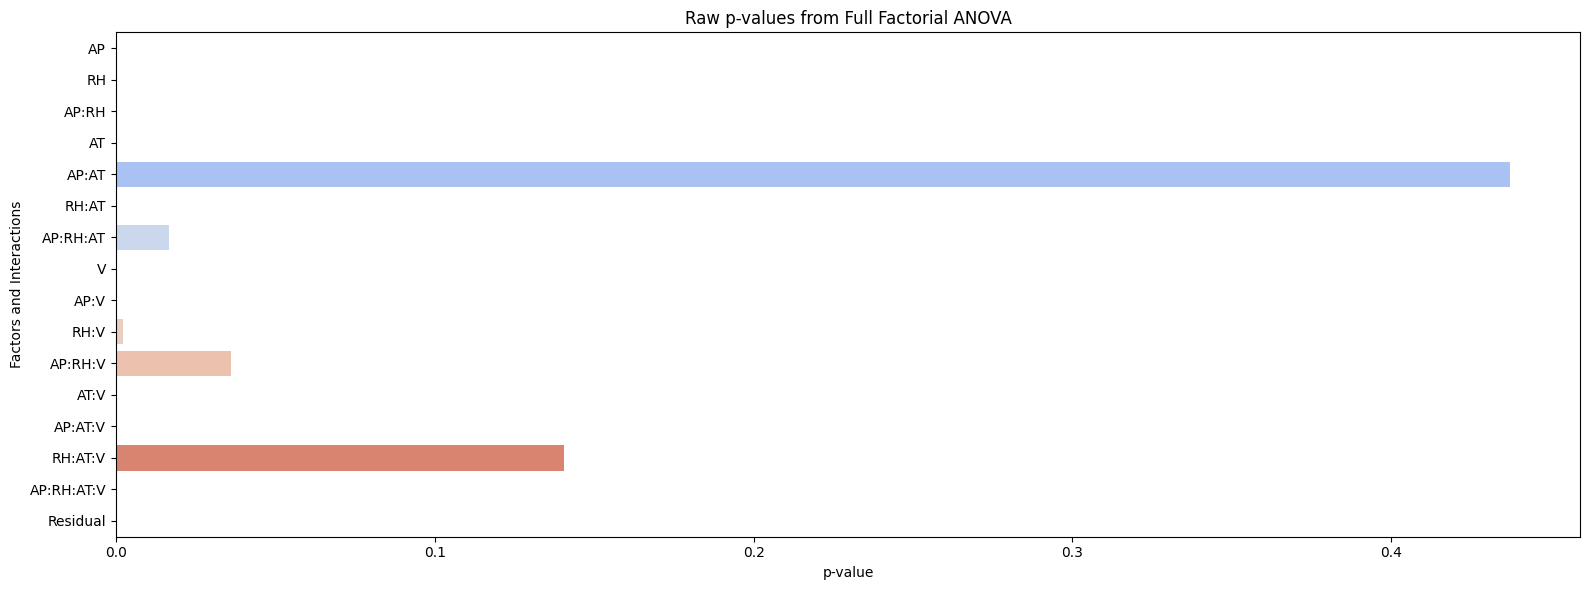

In [35]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

# Fit the full factorial model
formula = 'PE ~ AP * RH * AT * V'
model = ols(formula, data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Extract the F-statistic values and p-values
anova_results = anova_table[['F', 'PR(>F)']].reset_index()
anova_results.columns = ['Factor', 'F_statistic', 'p_value']

# Plot raw F-statistics in a wider figure
plt.figure(figsize=(16, 6))
sns.barplot(x='F_statistic', y='Factor', data=anova_results, palette='cool')
plt.title("Raw F-statistics from Full Factorial ANOVA")
plt.xlabel("F-statistic")
plt.ylabel("Factors and Interactions")
plt.tight_layout()
plt.show()

# Plot raw p-values in a separate, wider figure
plt.figure(figsize=(16, 6))
sns.barplot(x='p_value', y='Factor', data=anova_results, palette='coolwarm')
plt.title("Raw p-values from Full Factorial ANOVA")
plt.xlabel("p-value")
plt.ylabel("Factors and Interactions")
plt.tight_layout()
plt.show()

## Anova Log10
#### Good Model: A log10 F-statistic significantly greater than 0 
#### Bad Model: Values close to or less than 0 

In [36]:
import warnings
warnings.filterwarnings("ignore")

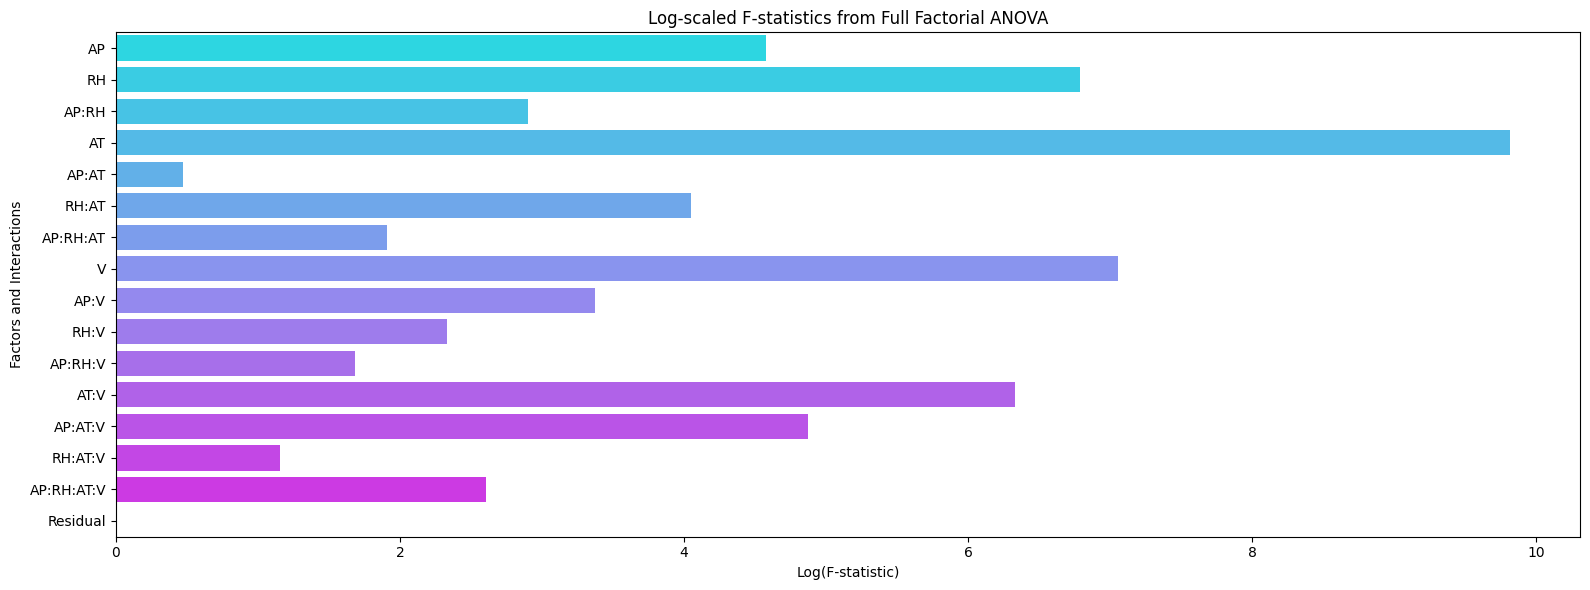

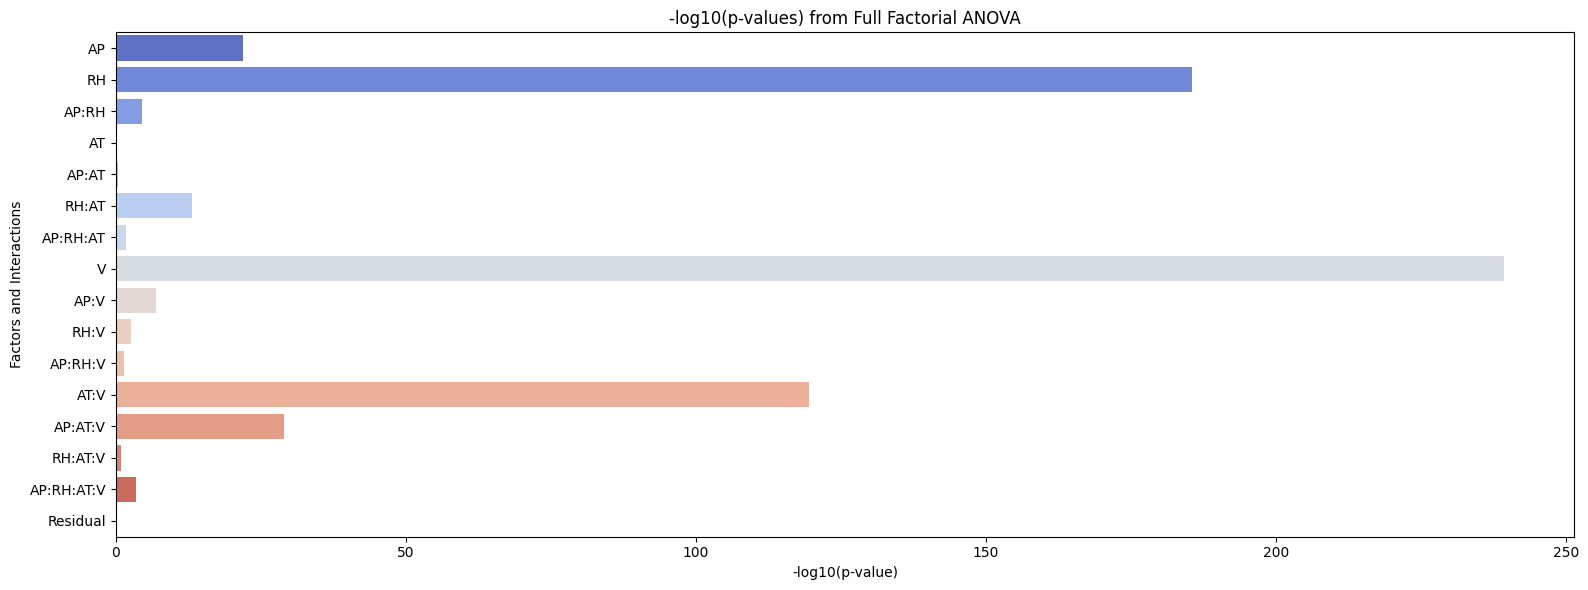

In [37]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Fit the full factorial model
formula = 'PE ~ AP * RH * AT * V'
model = ols(formula, data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Extract the F-statistic values and p-values
anova_results = anova_table[['F', 'PR(>F)']].reset_index()
anova_results.columns = ['Factor', 'F_statistic', 'p_value']

# Apply log transformations
anova_results['log_F_statistic'] = np.log1p(anova_results['F_statistic'])  # Log scale for F-statistic
anova_results['neg_log_p_value'] = -np.log10(anova_results['p_value'])  # Log scale for p-value

# Plot log-scaled F-statistics in a wider figure
plt.figure(figsize=(16, 6))
sns.barplot(x='log_F_statistic', y='Factor', data=anova_results, palette='cool')
plt.title("Log-scaled F-statistics from Full Factorial ANOVA")
plt.xlabel("Log(F-statistic)")
plt.ylabel("Factors and Interactions")
plt.tight_layout()
plt.show()

# Plot -log10(p-values) in a separate, wider figure
plt.figure(figsize=(16, 6))
sns.barplot(x='neg_log_p_value', y='Factor', data=anova_results, palette='coolwarm')
plt.title("-log10(p-values) from Full Factorial ANOVA")
plt.xlabel("-log10(p-value)")
plt.ylabel("Factors and Interactions")
plt.tight_layout()
plt.show()

## High log10 p value = lower raw p vale (greater significance)
## missing bar graphs for AT and AP:AT

### Risk groups = high p values > 0.05
### AP:AT and RH:AT:V

Higher bars on the plot (larger values of -log10(p-value)) indicate smaller p-values, which means higher significance.

Lower bars (closer to 0) mean larger p-values, which indicate lower significance.

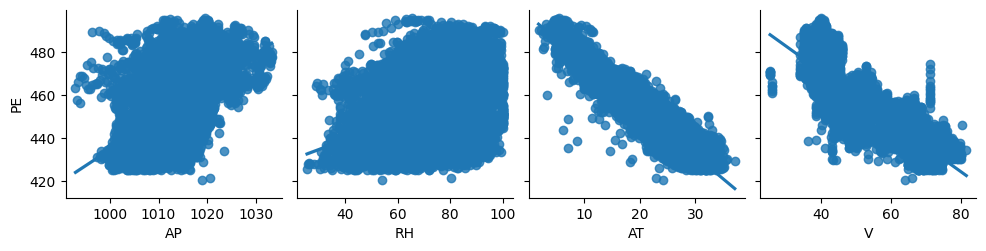

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot scatter plots to check linearity between each feature and the target (PE)
sns.pairplot(df, x_vars=['AP', 'RH', 'AT', 'V'], y_vars='PE', kind='reg')
plt.show()

 (b) Z-scores for detecting outliers numerically:

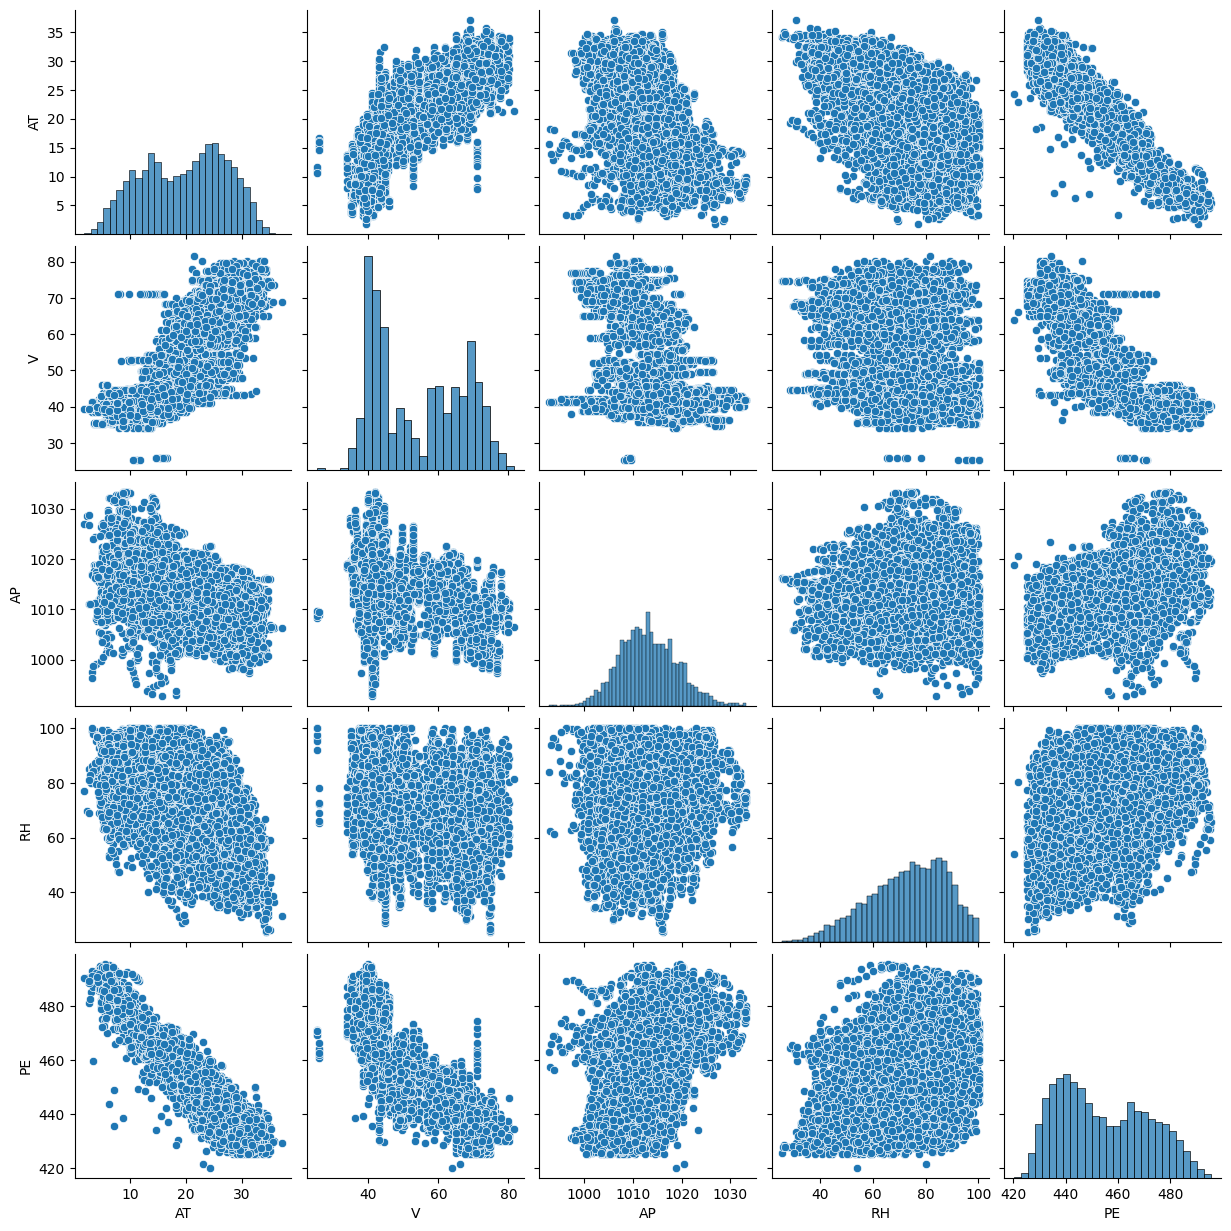

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
# Scatter plot to check relationships
sns.pairplot(df)
plt.show()

In [41]:
from scipy.stats import zscore

# Calculate Z-scores for each feature and target variable
df_z = df[['AP', 'RH', 'AT', 'V', 'PE']].apply(zscore)

# Combine original data with Z-scores
df_combined = df[['AP', 'RH', 'AT', 'V', 'PE']].copy()
for col in df_combined.columns:
    df_combined[f'{col}_Z'] = df_z[col]

# Identify outliers (absolute Z-score > 3)
outliers = (df_z.abs() > 3).any(axis=1)

# Show rows with outliers, including Z-scores
df_outliers = df_combined[outliers]
# print("Outliers detected with Z-scores:")
# print(df_outliers)

In [42]:
# Without outliers (absolute Z-score <= 3)
df_z = df[['AP', 'RH', 'AT', 'V', 'PE']].apply(zscore)
no_outliers = df[(df_z.abs() <= 3).all(axis=1)]

# Compare summary statistics
print("Original Data:")
print(df.describe())

print("\nWithout Outliers:")
print(no_outliers.describe())

Original Data:
                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000

Without Outliers:
                AT            V           AP           RH           PE
count  9510.000000  9510.000000  9510.000000  9510.000000  9510.000000
mean     19.692802    54.366760  1013.192105    73.324603   454.269644
std       7.433565    12.701365     5.792225    14.575318    17.037027
min       1.810000    25.360000   995.45000

## removing outliers = only small effect to mean or std dev

Use clustering techniques (like K-means) to identify whether outliers form distinct clusters. 

If they do, it suggests the outliers might be valid data points, representing a separate class.

### elbow method for choosing best cluster

This method evaluates the sum of squared distances between points and their assigned cluster center (inertia). As the number of clusters increases, the inertia decreases. The best number of clusters is at the "elbow" point where the inertia begins to level off.

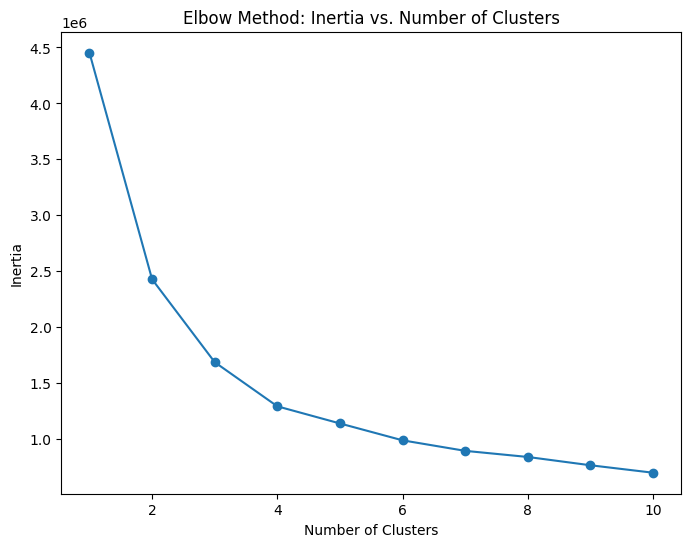

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define the range for number of clusters
inertia = []
cluster_range = range(1, 11)  # You can adjust the range

# Calculate inertia for different numbers of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[['AP', 'RH', 'AT', 'V']])  # Use your independent variables
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### sillhouette score

The Silhouette Score measures how similar a point is to its own cluster compared to other clusters.

The score ranges from -1 to 1, with higher values indicating better-defined clusters.

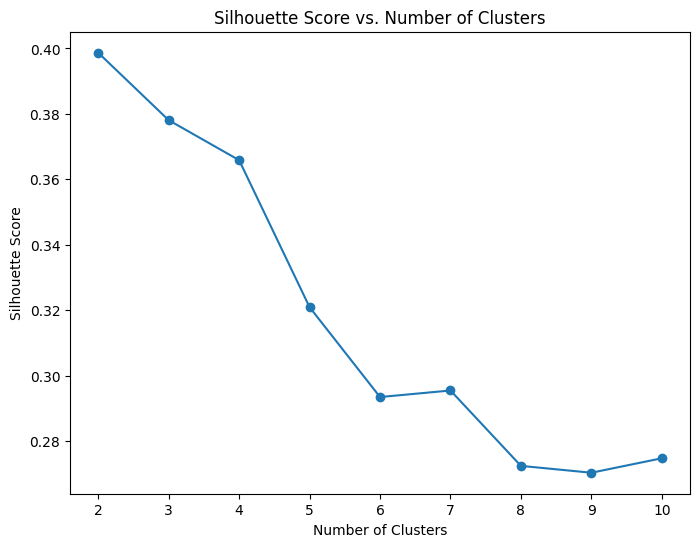

In [44]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define the range of clusters, starting from 2
cluster_range = range(2, 11)  # Adjust the range if needed

# Calculate silhouette score for different numbers of clusters
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df[['AP', 'RH', 'AT', 'V']])
    silhouette_avg = silhouette_score(df[['AP', 'RH', 'AT', 'V']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## K means clustering

After assigning individual points, the cluster centroids (average position of all the data points within that cluster) is updated to be the mean of all points in that cluster.

For example, if a cluster has 3 points with coordinates (x1,y1), (x2,y2), and (x3,y3), the centroid is found by averaging each coordinate.

K-means clustering with only 2 clusters can effectively visualize linear regression by simplifying complex relationships into two distinct groups, making it easier to identify patterns and trends in the data.

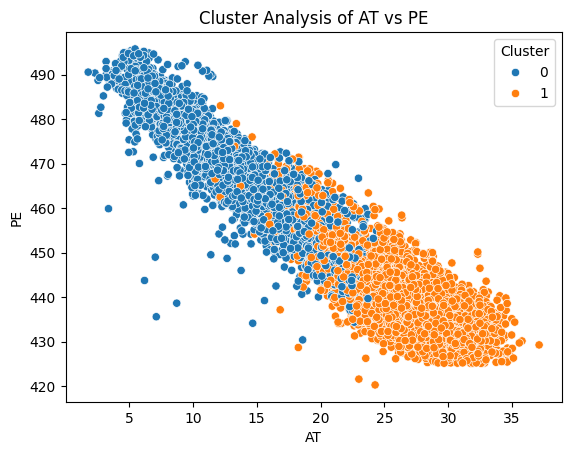

In [45]:
from sklearn.cluster import KMeans

indep = 'AT'

# Perform K-means clustering (k=3 as an example)
kmeans = KMeans(n_clusters=2)
df['Cluster'] = kmeans.fit_predict(df[['AP', 'RH', 'AT', 'V']])

# Visualize clusters
sns.scatterplot(x=indep, y='PE', hue='Cluster', data=df)
plt.title(f'Cluster Analysis of {indep} vs PE')
plt.show()

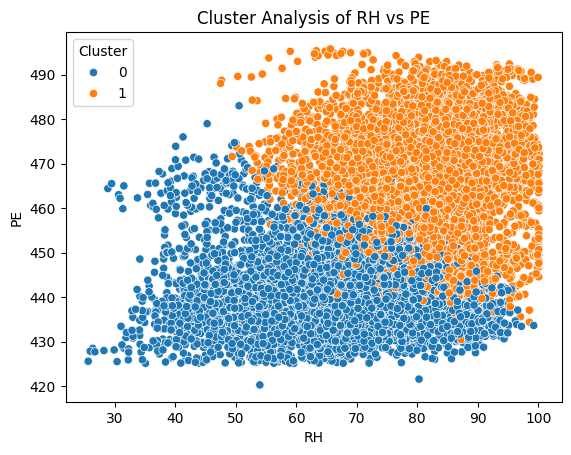

In [46]:
from sklearn.cluster import KMeans

indep = 'RH'

# Perform K-means clustering (k=3 as an example)
kmeans = KMeans(n_clusters=2)
df['Cluster'] = kmeans.fit_predict(df[['AP', 'RH', 'AT', 'V']])

# Visualize clusters
sns.scatterplot(x=indep, y='PE', hue='Cluster', data=df)
plt.title(f'Cluster Analysis of {indep} vs PE')
plt.show()

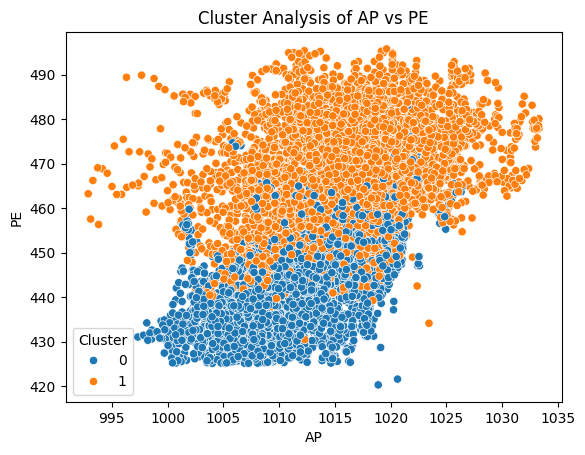

In [47]:
from sklearn.cluster import KMeans

indep = 'AP'

# Perform K-means clustering (k=3 as an example)
kmeans = KMeans(n_clusters=2)
df['Cluster'] = kmeans.fit_predict(df[['AP', 'RH', 'AT', 'V']])

# Visualize clusters
sns.scatterplot(x=indep, y='PE', hue='Cluster', data=df)
plt.title(f'Cluster Analysis of {indep} vs PE')
plt.show()

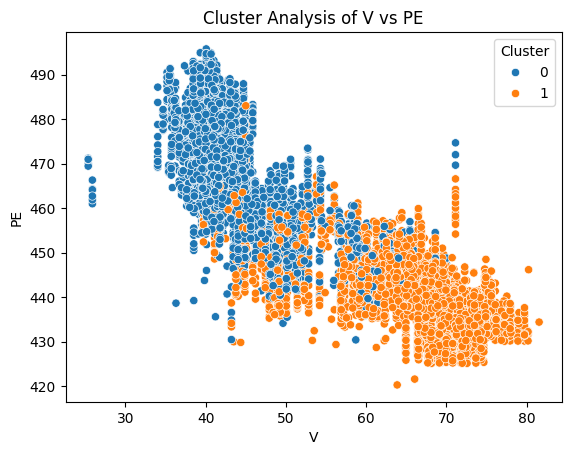

In [48]:
from sklearn.cluster import KMeans

indep = 'V'

# Perform K-means clustering (k=3 as an example)
kmeans = KMeans(n_clusters=2)
df['Cluster'] = kmeans.fit_predict(df[['AP', 'RH', 'AT', 'V']])

# Visualize clusters
sns.scatterplot(x=indep, y='PE', hue='Cluster', data=df)
plt.title(f'Cluster Analysis of {indep} vs PE')
plt.show()


A very scattered cluster indicates high variance within the cluster, meaning that the individual data points are far from the cluster centroid and from each other, 

resulting in a larger spread in their distances, which mathematically reflects greater uncertainty and less homogeneity in that group.

## Well-separated clusters indicate that the features are discriminating the data well.
## Better separation = Algorithim will be better at finding boundaries in a model.
## Risk groups, AP and V

<u><b>Data Points (Observations):</u></b> Each point corresponds to an individual observation (or data record) in the dataset.

The position of the point is determined by the values of its features (variables).

For example, in a 2D plot, each point has two coordinates (e.g., x and y) representing two features, while in higher dimensions, the plot shows a projection of the data.


<u><b>Cluster Assignment:</u></b> After running KMeans, each data point is assigned to a cluster based on its proximity to the cluster centroids.

Points that are closer together are considered to belong to the same cluster. Typically, different colors or markers are used on the plot to show which points belong to which clusters.

In [49]:
# Calculate mean of features for each cluster
cluster_summary = df.groupby('Cluster')[['AT', 'PE']].mean()
print(cluster_summary)

                AT          PE
Cluster                       
0        13.742578  467.311013
1        25.743001  441.017792


## T-test:
#### more suitable when comparing means of 2 groups
####  The t-statistic measures the difference between group means relative to the variability within the groups.

In [50]:
import pandas as pd
from scipy import stats
# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(df['AT'], df['PE'])

# Display the results
print(f'T-statistic: {t_statistic}, p-value: {p_value:.4f}')

T-statistic: -1753.5653812864073, p-value: 0.0000


In [51]:
import pandas as pd
from scipy import stats
# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(df['AP'], df['PE'])

# Display the results
print(f'T-statistic: {t_statistic}, p-value: {p_value:.4f}')

T-statistic: 3673.6176804462775, p-value: 0.0000


In [52]:
import pandas as pd
from scipy import stats
# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(df['V'], df['PE'])

# Display the results
print(f'T-statistic: {t_statistic}, p-value: {p_value:.4f}')

T-statistic: -1358.2525295219396, p-value: 0.0000


In [53]:
import pandas as pd
from scipy import stats
# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(df['RH'], df['PE'])

# Display the results
print(f'T-statistic: {t_statistic}, p-value: {p_value:.4f}')

T-statistic: -2116.3395262690497, p-value: 0.0000


In general, the larger the absolute value of the t-statistic, the stronger the evidence against the null hypothesis (which posits that there is no difference between the means).

If the p-value is significantly low (commonly less than 0.05), you can reject the null hypothesis, concluding that there is a statistically significant difference between the two means.

#### Lasso Output:
Best alpha: The alpha value that results in the lowest MSE.

Best MSE score: The best (lowest) cross-validated MSE score corresponding to the optimal alpha.

This process helps you choose the best regularization strength for your Lasso regression model on your dataset, minimizing the MSE.

In [54]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define features (X) and target (y)
X = df[['AP', 'AT', 'RH', 'V']]  # Features
y = df['PE']  # Target

# Step 1: Set up the pipeline (scaling + Lasso regression)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 2: Scale features
    ('lasso', Lasso())             # Step 3: Apply Lasso regression
])

# Step 4: Define the grid of alpha values to search over
param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}  # Range of alphas to tune

# Step 5: Set up the GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)

# Step 6: Fit the grid search to the data
grid_search.fit(X, y)

# Step 7: Output the best alpha value and the corresponding MSE score
print("Best alpha:", grid_search.best_params_['lasso__alpha'])
print("Best MSE score:", -grid_search.best_score_)

Best alpha: 0.001
Best MSE score: 20.80347511226623


## K-means  cross validation (for regression)

https://scikit-learn.org/stable/modules/cross_validation.html

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Define the feature matrix X and target vector y
X = df[['AP', 'AT', 'RH', 'V']]  # Features
y = df['PE']  # Target

# Define the linear regression model
model = LinearRegression()

# 5-fold cross-validation with negative mean squared error
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive for interpretation
mse_scores = - scores

print("Cross-validation MSE scores:", mse_scores)
print("Mean MSE score:", mse_scores.mean())

Cross-validation MSE scores: [20.69137771 22.95480205 19.59126147 20.78579791 19.99408646]
Mean MSE score: 20.80346512042863


These values represent the MSE for each of the 5 cross-validation splits.

The fact that the MSE scores across the 5 folds are similar (ranging from about 19.59 to 22.95) suggests that the model is relatively stable and performs consistently across different subsets of your data.

Aim to reduce the MSE because it measures prediction error. 

#### Output the fold number with MSE values:

In [56]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume df is your dataframe and you're using AP, AT, RH, V as features
X = df[['AP', 'AT', 'RH', 'V']]  # Features
y = df['PE']  # Target

# Step 1: Apply KMeans clustering (choose number of clusters k)
kmeans = KMeans(n_clusters=3, random_state=42)
X['cluster'] = kmeans.fit_predict(X)

# Step 2: Scale the data (optional, depends on the need for regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Perform K-fold cross-validation on the regression model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()

# Step 4: Store MSE scores for each fold
mse_scores = []
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = np.mean((y_pred - y_test) ** 2)
    mse_scores.append(mse)

# Step 5: Identify the fold with an MSE close to 19
for i, mse in enumerate(mse_scores):
    print(f"Fold {i+1} MSE: {mse}")
    if np.isclose(mse, 19, atol=0.5):  # Adjust tolerance if needed
        print(f"Selected fold: {i+1} with MSE of {mse}")
        selected_fold = i+1

Fold 1 MSE: 19.59060042123448
Fold 2 MSE: 21.067128054380575
Fold 3 MSE: 22.800036874150244
Fold 4 MSE: 19.67466261188024
Fold 5 MSE: 20.906292863464113


### Train from specific fold (not common)

In [57]:
from sklearn.model_selection import KFold
import numpy as np

# Define features (X) and target (y)
X = df[['AP', 'AT', 'RH', 'V']].values  # Features
y = df['PE'].values  # Target

# Step 1: Perform KFold split to isolate Fold 1
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = list(kf.split(X))

# Step 2: Select Fold 1 (first fold) data
train_index, test_index = splits[0]  # Fold 1
X_train, y_train = X[train_index], y[train_index]

# Step 3: Train the model on Fold 1 training data
pipeline.fit(X_train, y_train)

# Step 4: Get model coefficients and intercept (optional)
print("Model coefficients from Fold 1:", pipeline.named_steps['linear_reg'].coef_)
print("Model intercept from Fold 1:", pipeline.named_steps['linear_reg'].intercept_)

KeyError: 'linear_reg'

### Train from full dataset (preferred method)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define features (X) and target (y)
X = df[['AP', 'AT', 'RH', 'V']]  # Features
y = df['PE']  # Target

# Step 1: Set up a pipeline for scaling + linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('linear_reg', LinearRegression())  # Linear regression
])

# Step 2: Train on the entire dataset
pipeline.fit(X, y)

# Step 3: Get model coefficients and intercept (optional)
print("Model coefficients:", pipeline.named_steps['linear_reg'].coef_)
print("Model intercept:", pipeline.named_steps['linear_reg'].intercept_)